In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.preprocessing import robust_scale

# sklearn models
from sklearn import linear_model
from sklearn.svm import SVR

# Inputing Files

In [3]:
county_area = pd.read_csv('county_area.csv')
county_area = county_area.drop(["Areaname"], axis=1)
county_area = county_area.rename(columns={"STCOU": "fips"})
county_area

,fips,AREA
0,1001,604.49
1,1003,2027.08
2,1005,904.59
3,1007,625.50
4,1009,650.65
...,...,...
3123,56037,10491.73
3124,56039,4221.96
3125,56041,2087.66
3126,56043,2242.85


In [4]:
county_mask_use = pd.read_csv('mask_use.csv')
county_mask_use = county_mask_use.rename(columns={"COUNTYFP": "fips"})
county_mask_use

,fips,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...
3123,56037,0.061,0.295,0.230,0.146,0.268
3124,56039,0.095,0.157,0.160,0.247,0.340
3125,56041,0.098,0.278,0.154,0.207,0.264
3126,56043,0.204,0.155,0.069,0.285,0.287


In [5]:
county_cases = pd.read_csv('county_cases.csv')
county_cases = county_cases.drop(["county","state"], axis=1)
county_cases

,fips,cases,deaths
0,1001,2059,31
1,1003,6658,69
2,1005,1033,9
3,1007,840,14
4,1009,1932,25
...,...,...,...
3123,56037,462,2
3124,56039,747,1
3125,56041,431,3
3126,56043,144,7


In [6]:
county_pop = pd.read_csv('county_pop.csv', encoding='latin-1')
county_pop = county_pop.drop(['STNAME','CTYNAME'], axis=1)
county_pop = county_pop.rename(columns={"COUNTY": "fips"})
county_pop

,fips,POPESTIMATE2019
0,1001,55869
1,1003,223234
2,1005,24686
3,1007,22394
4,1009,57826
...,...,...
3123,56037,42343
3124,56039,23464
3125,56041,20226
3126,56043,7805


## Merging Dataframes Together

In [7]:
education = pd.read_csv('Education.csv')
education = education.rename(columns={"FIPS Code": "fips", 
                            "Less than a high school diploma, 2010-2014": "< HS",
                            "High school diploma only, 2010-2014":"HS", 
                            "Some college or associate's degree, 2010-2014": "Some College",
                            "Bachelor's degree or higher, 2010-2014": "Bachelors",
                            "Percent of adults with less than a high school diploma, 2010-2014" : "% < HS",
                            "Percent of adults with a high school diploma only, 2010-2014" : "% HS",
                            "Percent of adults completing some college or associate's degree, 2010-2014" : "% Some College",
                            "Percent of adults with a bachelor's degree or higher, 2010-2014" : "% Bachelors"})

education = education.drop(["State", "Area name"], axis=1)
education

,fips,< HS,HS,Some College,Bachelors,% < HS,% HS,% Some College,% Bachelors
0,0,28587748.0,58440600.0,60821634.0,61206147.0,13.7,28.0,29.1,29.3
1,1000,524368.0,999761.0,951960.0,741813.0,16.3,31.1,29.6,23.1
2,1001,5012.0,12139.0,11132.0,7950.0,13.8,33.5,30.7,21.9
3,1003,14615.0,38401.0,42104.0,38147.0,11.0,28.8,31.6,28.6
4,1005,4790.0,6300.0,5183.0,2563.0,25.4,33.4,27.5,13.6
...,...,...,...,...,...,...,...,...,...
3278,72145,17986.0,4372.0,8782.0,7330.0,46.8,11.4,22.8,19.1
3279,72147,2283.0,2371.0,927.0,705.0,36.3,37.7,14.7,11.2
3280,72149,5242.0,5326.0,2646.0,2558.0,33.2,33.8,16.8,16.2
3281,72151,8553.0,7161.0,5330.0,3489.0,34.9,29.2,21.7,14.2


In [8]:
def new_normal(table):
    normal = robust_scale(table)
    return normal

In [9]:
df = county_pop.merge(county_mask_use, how='left', on="fips")
df = df.merge(county_area, how="left", on="fips")
df = df.merge(county_cases, how="left", on="fips")


df['POP_DEN'] = df['POPESTIMATE2019'] / df['AREA']
df['POP_DENxALWAYS'] = df['POP_DEN'] * df['ALWAYS']
# df['POP_DENxFREQUENTLY'] =df['POP_DEN'] * df['FREQUENTLY']
# df['POP_DENxSOMETIMES'] = df['POP_DEN'] * df['SOMETIMES']
# df['POP_DENxRARELY'] = df['POP_DEN'] * df['RARELY']
# df['POP_DENxNEVER'] = df['POP_DEN'] * df['NEVER']
# df['POPxALWAYS'] = df['POPESTIMATE2019'] * df['ALWAYS']
# df['POPxFREQUENTLY'] =df['POPESTIMATE2019'] * df['FREQUENTLY']
# df['POPxSOMETIMES'] = df['POPESTIMATE2019'] * df['SOMETIMES']
# df['POPxRARELY'] = df['POPESTIMATE2019'] * df['RARELY']
# df['POPxNEVER'] = df['POPESTIMATE2019'] * df['NEVER']

df = df.merge(education, how="left", on="fips")
df['% < HS']  = df['% < HS'] / 100
df['% HS'] = df['% HS'] / 100
df['% Some College'] = df['% Some College'] / 100
df['% Bachelors'] = df['% Bachelors'] / 100

df.insert(0, 'Ones', 1)

In [10]:
column_titles =  ['POPESTIMATE2019', 'NEVER',
                  'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'AREA', 
                  'POP_DEN', 'POP_DENxALWAYS', '< HS', 'HS', 'Some College',
                  'Bachelors', '% < HS', '% HS', '% Some College', '% Bachelors']

new_df = df.reindex(columns=column_titles)
normal_all = new_normal(new_df)
normal_df = pd.DataFrame(normal_all)
normal_df.columns = column_titles
normal_df['fips'] = df['fips']
normal_df = normal_df.merge(county_cases, how="left", on="fips")
column_titles = ['fips','cases','deaths','POPESTIMATE2019', 'NEVER',
                 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'AREA',
                 '< HS', 'HS', 'Some College','Bachelors', 
                 '% < HS', '% HS', '% Some College', '% Bachelors']

normal_df = normal_df.reindex(columns=column_titles)

## Normalize Data

In [11]:
def normalize(column):
    normal = []
    for value in column:
        value = (value - min(column)) / (max(column) - min(column))
        normal.append(value)
    return normal

## Graphs

fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['ALWAYS'][i], df['NEVER'][i])
plt.xlabel('Percentage of Mask Use')
plt.ylabel('Percentage of NO Mask Use')
plt.title('Percentage Mask Use vs. Percent NO Mask Use')
plt.show()

fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['POP_DEN'][i], df['cases'][i])
plt.xlabel('Population density')
plt.ylabel('Cases')
plt.title('Population Density vs. Cases')
plt.show()

fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['POP_DEN'][i], df['deaths'][i])
plt.xlabel('Population Density')
plt.ylabel('Deaths')
plt.title('Population Density vs. Deaths')
plt.show()

## Split Data

In [12]:
def split(X, Y, size):
    return train_test_split(X, Y, test_size=size)

# Models

In [15]:
#A train test split function using a random state of 0
def split(X, Y, size):
    return train_test_split(X, Y, test_size=size, random_state=0)

## SVM

In [16]:

X = normal_df.drop(['cases','fips','deaths','AREA'], axis =1)
normal_svm_data = np.array(X)
x_train, x_test, y_train, y_test = split(X,np.log(df['cases']), .2)
normal_df.describe()
np.shape(normal_df)

(3128, 18)

In [17]:

kernels = ['rbf', 'linear', 'poly','sigmoid']
outs = []
for k in kernels:
    svr = SVR(kernel=k)
    svr.fit(x_train, y_train)
    svr_predict = svr.predict(x_test)
    outs.append(MSE(y_test, svr_predict))
optimal_kernel = kernels[outs.index(min(outs))]
print('Best kernel is:', optimal_kernel)
print('With average MSE of:', min(outs))

Best kernel is: rbf
With average MSE of: 0.716381691529606


In [18]:
regs = [1,2,5,200]
outs = []
for reg in regs:
    svr = SVR(kernel=optimal_kernel, C=reg)
    svr.fit(x_train, y_train)
    svr_predict = svr.predict(x_test)
    outs.append(MSE(y_test, svr_predict))
optimal_C = regs[outs.index(min(outs))]
print('Best C value is:', optimal_C)
print('With average MSE of:', min(outs))


Best C value is: 200
With average MSE of: 0.5353971161911683


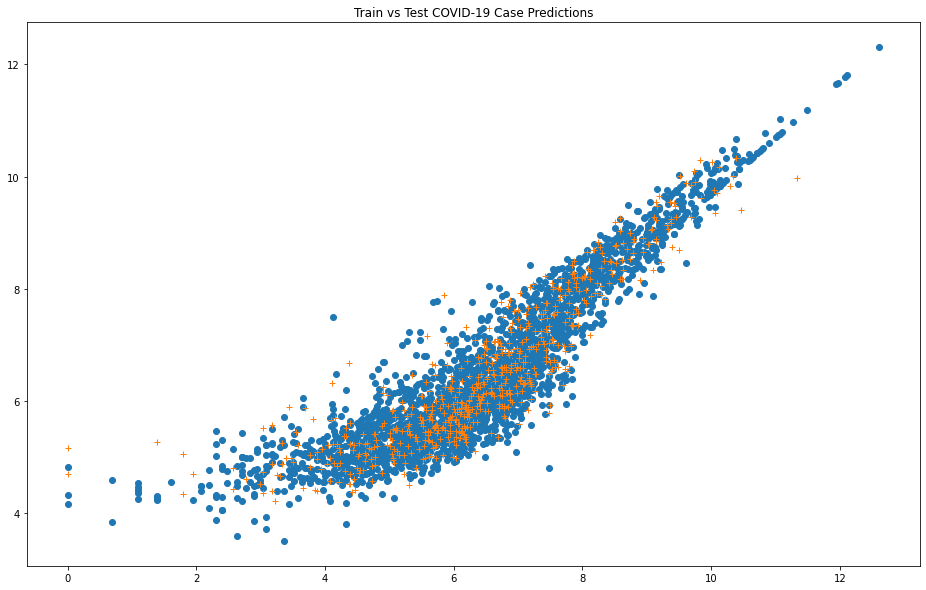

MSE =  0.5730638406461296
Accuracy Score =  0.7742715495107139


In [19]:
svr = SVR(kernel=optimal_kernel, C=31, epsilon = .3)
svr.fit(x_train, y_train)

y_train_pred = svr.predict(x_train)
y_test_pred = svr.predict(x_test)

fig, ax = plt.subplots(figsize=(16,10))
plt.plot(y_train, y_train_pred,'o')
plt.plot(y_test, y_test_pred, '+')
plt.title('Train vs Test COVID-19 Case Predictions')
plt.show()
    

print("MSE = ", MSE(y_test, svr.predict(x_test)))
print("Accuracy Score = ", svr.score(x_test,y_test))

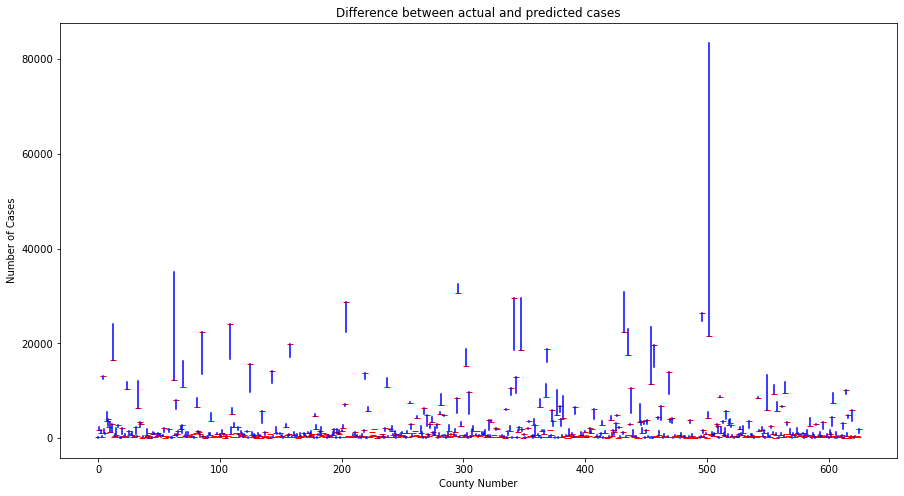

In [21]:
fig, ax = plt.subplots(figsize=(15,8))
y_test_pred = svr.predict(x_test)
y_df = pd.DataFrame(y_test)
#plt.ylim((0,3))
for i in range(len(x_test.index)):
    plt.plot(i, np.exp(y_test_pred[i]),'_r')
    plt.plot([i,i], [np.exp(y_test_pred[i]),np.exp(y_df.iloc[i,0])], 'b')
plt.title('Difference between actual and predicted cases')
plt.xlabel('County Number')
plt.ylabel('Number of Cases')
plt.show()

In [36]:
c_values = np.arange(1, 52 ,5)
epsilon_values = np.arange(.1, .51 , .1)
clf = SVR(kernel = 'rbf')
grid = {'C':c_values, 'epsilon':epsilon_values}
clf_cv = GridSearchCV(estimator = clf, param_grid = grid)
clf_cv.fit(x_train, y_train)
best_epsilon = clf_cv.best_params_['epsilon']
best_c = clf_cv.best_params_['C']

print('Best epsilon: ', best_epsilon)
print('Best C: ', best_c)


Best epsilon:  0.30000000000000004
Best C:  31
